In [29]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [30]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Pocket2mol
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [31]:
uru.rd_set_image_size(300,300)

### Reading the data from Pocket2mol

See if they are valid or not

In [32]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Pocket2mol/combined_SMILES_pocket2mol.txt') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

1345


1345

Convert SMILES and name of them to a dataframe

In [33]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,O=C(O)C1C=CCC1
1,Cc1nc(=O)n(O)[nH]1
2,N=C1N=C(N)N=C1N
3,NC(=O)c1ccccc1
4,c1ccc2occc2c1
...,...
1340,O=C(O)c1ccc(O)c(O)c1
1341,O=C(O)c1cccc(O)c1O
1342,O=C(O)c1cc(O)cc(O)c1
1343,Cc1cc(O)ccc1C(=O)O


Add an RDKit molecule to the dataframe

In [34]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

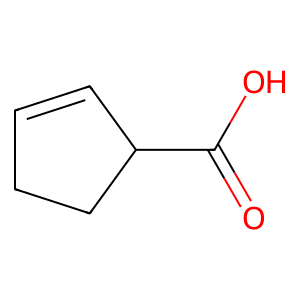

In [35]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [36]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0              [C1=CCCC1]
1       [O=c1nc[nH][nH]1]
2           [N=C1C=NC=N1]
3              [c1ccccc1]
4         [c1ccc2occc2c1]
              ...        
1340           [c1ccccc1]
1341           [c1ccccc1]
1342           [c1ccccc1]
1343           [c1ccccc1]
1344           [c1ccccc1]
Name: ring_sytems, Length: 1345, dtype: object

In [37]:
df.ring_sytems.values

array([list(['C1=CCCC1']), list(['O=c1nc[nH][nH]1']),
       list(['N=C1C=NC=N1']), ..., list(['c1ccccc1']), list(['c1ccccc1']),
       list(['c1ccccc1'])], dtype=object)

See how many times each ring system occurs

In [38]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
3,c1ccccc1,340
6,c1ccncc1,60
26,c1ccc2ccccc2c1,36
17,c1cncnc1,26
9,C1CCCC1,18
...,...,...
426,O=C1N=CCC2=CC3=CN=CC3C=C12,1
427,O=c1ccn2ccccc2n1,1
428,c1cc2c3c(ccc4cnncc43)nn2cn1,1
429,C1=NN=C2CN3C=CCc4nncc(c43)C=12,1


View the ring system frequencies

In [39]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [40]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [41]:
res

0              [(C1=CCCC1, 1686)]
1       [(O=c1nc[nH][nH]1, 2131)]
2              [(N=C1C=NC=N1, 0)]
3           [(c1ccccc1, 2260082)]
4        [(c1ccc2occc2c1, 14340)]
                  ...            
1340        [(c1ccccc1, 2260082)]
1341        [(c1ccccc1, 2260082)]
1342        [(c1ccccc1, 2260082)]
1343        [(c1ccccc1, 2260082)]
1344        [(c1ccccc1, 2260082)]
Name: mol, Length: 1345, dtype: object

In [42]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ca50>,[N=C1C=NC=N1],N=C1C=NC=N1,0
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340
...,...,...,...,...,...
1340,O=C(O)c1ccc(O)c(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85850>,[c1ccccc1],c1ccccc1,2260082
1341,O=C(O)c1cccc(O)c1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd858c0>,[c1ccccc1],c1ccccc1,2260082
1342,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082
1343,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd859a0>,[c1ccccc1],c1ccccc1,2260082


In [43]:
df_ring_appearance_0 = df[df.min_freq == 0]
df_ring_appearance_0

,SMILES,mol,ring_sytems,min_ring,min_freq
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ca50>,[N=C1C=NC=N1],N=C1C=NC=N1,0
5,CC1=C=CC(C)=NC1=O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cba0>,[O=C1C=C=CC=N1],O=C1C=C=CC=N1,0
8,C1=Cc2nccnc2C1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ccf0>,[C1=Cc2nccnc2C1],C1=Cc2nccnc2C1,0
40,COC1=CCC2=CC=NC2=C1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8daf0>,[C1=CCC2=CC=NC2=C1],C1=CCC2=CC=NC2=C1,0
50,O=CC1=CC=C=C1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8df50>,[C1=CC=CC=1],C1=CC=CC=1,0
...,...,...,...,...,...
1236,O=C1C=C=CC=C1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd9aa40>,[O=C1C=C=CC=C1],O=C1C=C=CC=C1,0
1251,O=C1CC(C(=O)O)C=N1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd9b0d0>,[O=C1CCC=N1],O=C1CCC=N1,0
1252,O=C1C=C(O)C(=O)C=N1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd9b140>,[O=C1C=CC(=O)N=C1],O=C1C=CC(=O)N=C1,0
1271,[O-][n+]1ccc2c(c1)C=CC2,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd9b990>,[C1=Cc2c[nH+]ccc2C1],C1=Cc2c[nH+]ccc2C1,0


In [44]:
df_ring_appearance_0['SMILES'].to_csv('p2m_ring_appearance_0.smi',index=False,header=False)

In [45]:
df_ring_appearance_100more = df[df.min_freq > 100]
df_ring_appearance_100more

,SMILES,mol,ring_sytems,min_ring,min_freq
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cc10>,[c1ccncc1],c1ccncc1,231698
...,...,...,...,...,...
1340,O=C(O)c1ccc(O)c(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85850>,[c1ccccc1],c1ccccc1,2260082
1341,O=C(O)c1cccc(O)c1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd858c0>,[c1ccccc1],c1ccccc1,2260082
1342,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082
1343,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd859a0>,[c1ccccc1],c1ccccc1,2260082


In [46]:
df_ring_appearance_100more['SMILES'].to_csv('p2m_ring_appearance_100more.smi',index=False,header=False)

In [47]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [48]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Charges were rearranged

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Charges were rearranged

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefined stereo

[20:50:32] WARNING: Omitted undefine

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4..."
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(..."
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ca50>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,..."
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2..."
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H
...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85770>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd857e0>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd859a0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...


How many molecules contains ring structure?

In [49]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4..."
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(..."
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ca50>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,..."
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2..."
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H
...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85770>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd857e0>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd859a0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...


In [50]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4..."
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(..."
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2..."
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cc10>,[c1ccncc1],c1ccncc1,231698,"InChI=1S/C7H10N2/c1-5-3-7(8)9-4-6(5)2/h3-4H,1-..."
...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85770>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd857e0>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd859a0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...


### How many of them could pass PAINS filter?

Get a list of rules

In [51]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [52]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [53]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [54]:
reos.pandas_mols(df.mol)

  0%|          | 0/1105 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
1100,ok,ok
1101,ok,ok
1102,ok,ok
1103,ok,ok


In [55]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/1105 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7b7d83170270>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",ok,ok
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8c900>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",ok,ok
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8ca50>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",ok,ok
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cac0>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",ok,ok
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd8cb30>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,ok,ok
...,...,...,...,...,...,...,...,...
1099,CC(=O)Oc1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85700>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-6(9)11-8-4-2-7(10)3-5-8/h2-...,ok,ok
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85770>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,ok,ok
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd857e0>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,ok,ok
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7b7d7bd85930>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,ok,ok


Test all filters from rd filter

In [56]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/1105 [00:00<?, ?it/s]

Glaxo 0.9601809954751132 ['Glaxo'] 1061


  0%|          | 0/1105 [00:00<?, ?it/s]

Dundee 0.7158371040723982 ['Dundee'] 791


  0%|          | 0/1105 [00:00<?, ?it/s]

BMS 0.8751131221719457 ['BMS'] 967


  0%|          | 0/1105 [00:00<?, ?it/s]

SureChEMBL 0.8072398190045249 ['SureChEMBL'] 892


  0%|          | 0/1105 [00:00<?, ?it/s]

MLSMR 0.7176470588235294 ['MLSMR'] 793


  0%|          | 0/1105 [00:00<?, ?it/s]

Inpharmatica 0.8 ['Inpharmatica'] 884


  0%|          | 0/1105 [00:00<?, ?it/s]

LINT 0.7285067873303167 ['LINT'] 805


### How many of them could pass filters suggested by Dr.Reymond?

In [28]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True
...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True


In [29]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True
...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True


### How many of them could pass RO5?

In [30]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


In [31]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1686,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,2131,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,2260082,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,14340,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,11659,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [32]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0            [(C1=CCCC1, 1131740046)]
1       [(O=c1nc[nH][nH]1, 47773934)]
2                  [(N=C1C=NC=N1, 0)]
3           [(c1ccccc1, 21243538754)]
4        [(c1ccc2occc2c1, 354330794)]
                    ...              
1100     [(O=c1cccc[nH]1, 263027600)]
1101     [(O=c1cccc[nH]1, 263027600)]
1102        [(c1ccccc1, 21243538754)]
1103        [(c1ccccc1, 21243538754)]
1104        [(c1ccccc1, 21243538754)]
Name: mol, Length: 1105, dtype: object

In [33]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1131740046,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,47773934,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,354330794,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


In [34]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [35]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1131740046,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,47773934,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,354330794,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d8c0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H10N2/c1-5-3-7(8)9-4-6(5)2/h3-4H,1-...",True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


In [36]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1131740046,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,47773934,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,354330794,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d8c0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H10N2/c1-5-3-7(8)9-4-6(5)2/h3-4H,1-...",True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d540>,[C1=CCCC1],C1=CCCC1,1131740046,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,47773934,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d770>,[c1ccccc1],c1ccccc1,21243538754,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d7e0>,[c1ccc2occc2c1],c1ccc2occc2c1,354330794,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x77b65d99d8c0>,[c1ccncc1],c1ccncc1,9975620076,"InChI=1S/C7H10N2/c1-5-3-7(8)9-4-6(5)2/h3-4H,1-...",True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2420>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,263027600,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c25e0>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x77b65d9c2650>,[c1ccccc1],c1ccccc1,21243538754,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [40]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0             [(C1=CCCC1, 3538056)]
1       [(O=c1nc[nH][nH]1, 730646)]
2                [(N=C1C=NC=N1, 0)]
3           [(c1ccccc1, 503413992)]
4        [(c1ccc2occc2c1, 4577561)]
                   ...             
1100     [(O=c1cccc[nH]1, 4043767)]
1101     [(O=c1cccc[nH]1, 4043767)]
1102        [(c1ccccc1, 503413992)]
1103        [(c1ccccc1, 503413992)]
1104        [(c1ccccc1, 503413992)]
Name: mol, Length: 1105, dtype: object

In [41]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1540>,[C1=CCCC1],C1=CCCC1,3538056,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,730646,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
2,N=C1N=C(N)N=C1N,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1700>,[N=C1C=NC=N1],N=C1C=NC=N1,0,"InChI=1S/C3H5N5/c4-1-2(5)8-3(6)7-1/h(H5,4,5,6,...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1770>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a17e0>,[c1ccc2occc2c1],c1ccc2occc2c1,4577561,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,4043767,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6500>,[O=c1cccc[nH]1],O=c1cccc[nH]1,4043767,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6650>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c66c0>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True


In [42]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [43]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,O=C(O)C1C=CCC1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1540>,[C1=CCCC1],C1=CCCC1,3538056,"InChI=1S/C6H8O2/c7-6(8)5-3-1-2-4-5/h1,3,5H,2,4...",True,True
1,Cc1nc(=O)n(O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1690>,[O=c1nc[nH][nH]1],O=c1nc[nH][nH]1,730646,"InChI=1S/C3H5N3O2/c1-2-4-3(7)6(8)5-2/h8H,1H3,(...",True,True
3,NC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a1770>,[c1ccccc1],c1ccccc1,503413992,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",True,True
4,c1ccc2occc2c1,<rdkit.Chem.rdchem.Mol object at 0x7575df1a17e0>,[c1ccc2occc2c1],c1ccc2occc2c1,4577561,InChI=1S/C8H6O/c1-2-4-8-7(3-1)5-6-9-8/h1-6H,True,True
6,Cc1cnc(N)cc1C,<rdkit.Chem.rdchem.Mol object at 0x7575df1a18c0>,[c1ccncc1],c1ccncc1,110130832,"InChI=1S/C7H10N2/c1-5-3-7(8)9-4-6(5)2/h3-4H,1-...",True,True
...,...,...,...,...,...,...,...,...
1100,NC(=O)c1c(N)cc[nH]c1=O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6490>,[O=c1cccc[nH]1],O=c1cccc[nH]1,4043767,InChI=1S/C6H7N3O2/c7-3-1-2-9-6(11)4(3)5(8)10/h...,True,True
1101,Cc1cc(C=O)cc(=O)n1O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6500>,[O=c1cccc[nH]1],O=c1cccc[nH]1,4043767,InChI=1S/C7H7NO3/c1-5-2-6(4-9)3-7(10)8(5)11/h2...,True,True
1102,O=C(O)c1cc(O)cc(O)c1,<rdkit.Chem.rdchem.Mol object at 0x7575df1c6650>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C7H6O4/c8-5-1-4(7(10)11)2-6(9)3-5/h1-...,True,True
1103,Cc1cc(O)ccc1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7575df1c66c0>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C8H8O3/c1-5-4-6(9)2-3-7(5)8(10)11/h2-...,True,True
